In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

In [86]:
import math

def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    for line in lines:
        if is_possible_laneline(line):
            for x1,y1,x2,y2 in line:
                cv2.line(img, (x1, y1), (x2, y2), color, thickness)

slope_10 = math.pi/18
min_slope = math.tan(slope_10)
max_slope = math.tan(slope_10 *  8)
def is_possible_laneline(line):
    x1, y1, x2, y2 = line[0]
    slope = (y2 - y1)/(x2 - x1)
    isLeftLane = (min_slope <= slope) and (slope <= max_slope) # Slope assumes to be between 10 and 80 degree  
    isRightLane =  (-max_slope <= slope) and (slope <= -min_slope)
    return isLeftLane or isRightLane

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    return cv2.addWeighted(initial_img, α, img, β, λ)

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


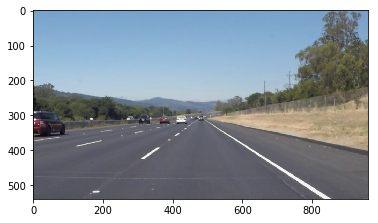

In [84]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image) 

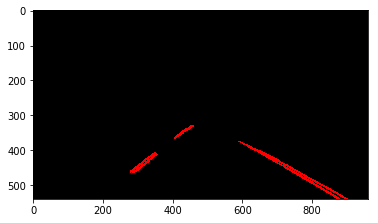

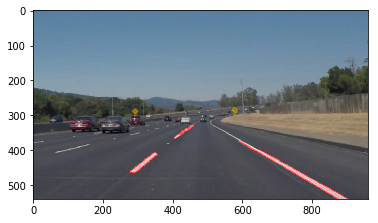

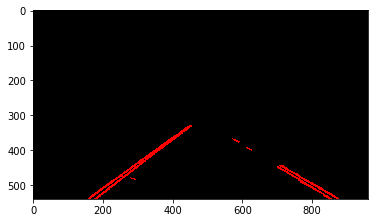

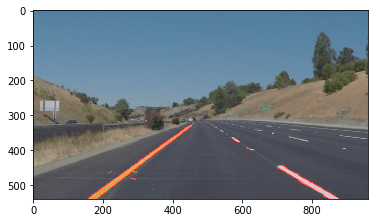

In [87]:
def imshow(img, gray=True, title=""):
    plt.figure()
    if gray:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(img)
    if title:
        plt.title(title)
        
def findLane(initial_img):
    img = np.copy(initial_img)
    img = grayscale(img)
    img = canny(img, low_threshold=50, high_threshold=150)  
    img = gaussian_blur(img, kernel_size=3)  
    #imshow(img)
    imshape = image.shape  
    vertices = np.array([[(0,imshape[0]),(450, 330), (490, 330), (imshape[1],imshape[0])]], dtype=np.int32)
    img = region_of_interest(img, vertices)

    img = hough_lines(img, rho=2, theta=np.pi/180, threshold=15, min_line_len=15, max_line_gap=10)
    imshow(img)
    img = weighted_img(img, initial_img, α=0.8, β=1., λ=0.)

    return img

img = mpimg.imread("test_images/test.jpg")
img = findLane(img)
imshow(img)

img = mpimg.imread("test_images/solidYellowCurve2.jpg")
img = findLane(img)
imshow(img)


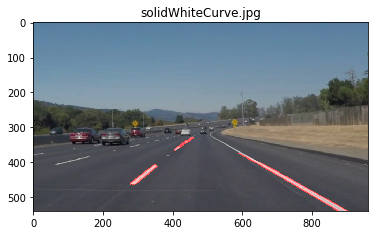

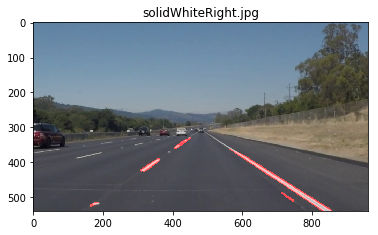

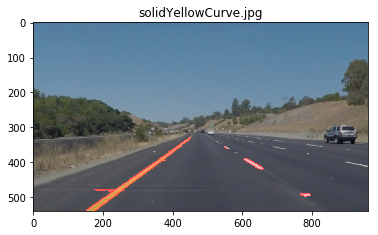

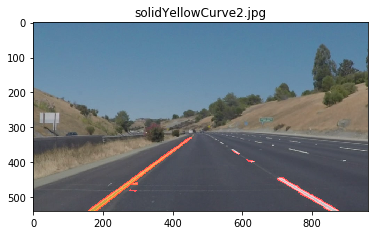

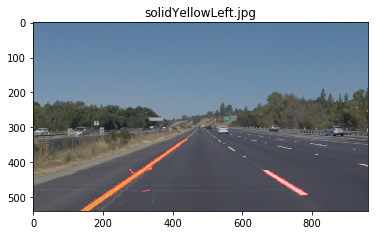

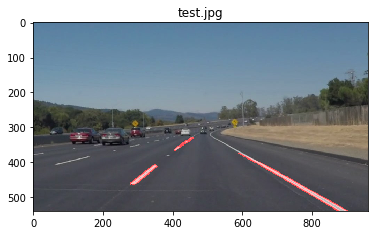

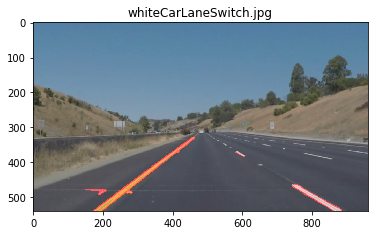

In [66]:
import os
os.listdir("test_images/")
for file in os.listdir("test_images/"):
    img = mpimg.imread("test_images/" + file)
    img = findLane(img)
    imshow(img, title=file)
    mpimg.imsave("test_images_output/" + file, img)

In [67]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def process_image(image):
    return findLane(image)

In [68]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:05<00:00, 44.20it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 5.46 s


In [69]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))